### Lecture 2 of CMU16-745 2024

Convert Julia to Python 

file integrators.ipynb

Use pydrake for forwarddiff function. (JAX does not work on my MAC M1.)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 


In [2]:
def pendulum_dynamics(x):
    l = 1.0
    g = 9.81
    theta = x[0]
    theta_dot = x[1]
    theta_ddot = -(g/l)*np.sin(theta)
    return np.array([theta_dot,theta_ddot]) 

In [13]:
def pendulum_forward_euler(func, x0, Tf, h):
    t = np.arange(0,Tf,h)
    x_hist = np.zeros((len(x0),len(t)))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        x_hist[:,k+1] = x_hist[:,k] + h*func(x_hist[:,k])
    
    return x_hist, t

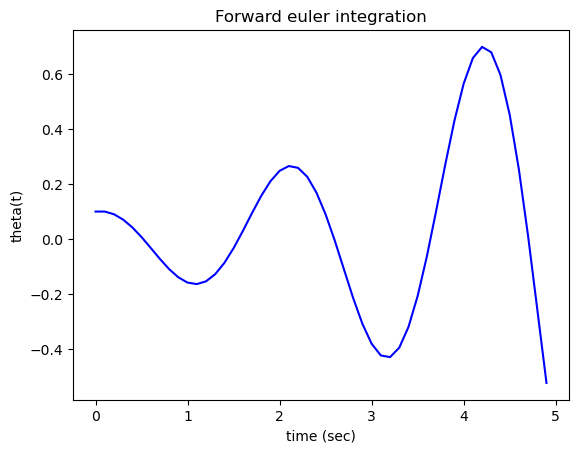

In [14]:
x0 = np.array([.1,0])
h = 0.1
x_hist1, t_hist1 = pendulum_forward_euler(pendulum_dynamics, x0, 5, h)
plt.figure()
plt.plot(t_hist1, x_hist1[0,:],'b-')
plt.xlabel('time (sec)')
plt.ylabel('theta(t)')
plt.title('Forward euler integration')
plt.show()

In [5]:
def pendulum_euler_Ad(x0, h):
    g = 9.81
    Ad = np.array([[1, h],[-g*h*np.cos(x0[0]), 1]])
    return Ad

In [6]:
x_0 = np.array([.1,0])
np.linalg.eigvals(pendulum_euler_Ad(x0,0.1))

array([1.+0.31242584j, 1.-0.31242584j])

In [7]:
np.linalg.norm(np.linalg.eigvals(pendulum_euler_Ad(x0,0)))

1.4142135623730951

(100,)
(100,)


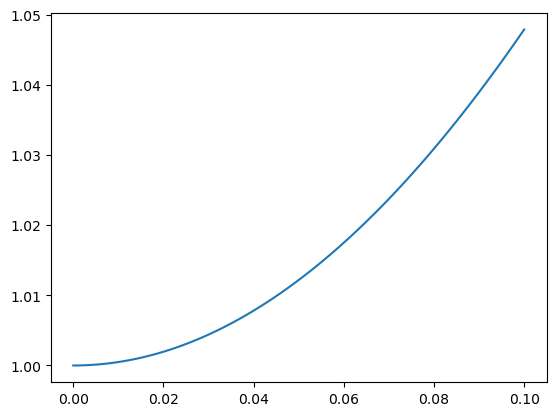

In [9]:
eignorms = np.zeros((100,))
print(eignorms.shape)
hvec = np.linspace(0,0.1,100)
print(hvec.shape)
x_0 = np.array([0,0])
for k in range(len(eignorms)):
    eignorms[k] = np.max(abs(np.linalg.eigvals(pendulum_euler_Ad(x_0,hvec[k]))))
plt.plot(hvec, eignorms)
plt.show()

In [ ]:
# RK4 integration

In [11]:
def fd_pendulum_rk4(xk,h):
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5*h*f1)
    f3 = pendulum_dynamics(xk + 0.5*h*f2)
    f4 = pendulum_dynamics(xk + h*f3)
    return xk + (h/6.0)*(f1 + 2*f2 +2*f3 + f4)
    

In [12]:
def pendulum_rk4(func, x0, Tf, h):
    t = np.arange(0,Tf,h)
    x_hist = np.zeros((len(x0),len(t)))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        x_hist[:,k+1] = fd_pendulum_rk4(x_hist[:,k], h)
    
    return x_hist, t

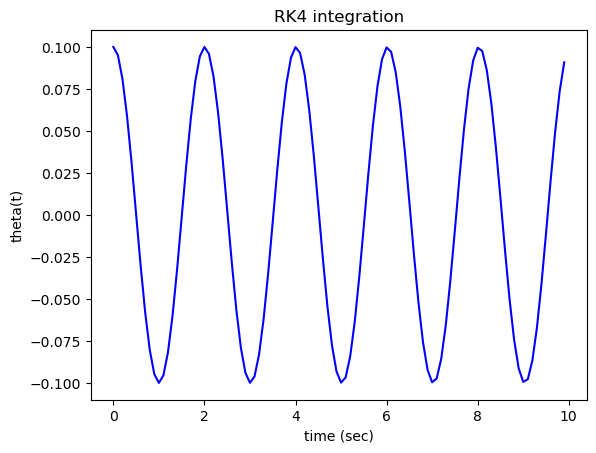

In [16]:
x0 = np.array([.1,0])
h = 0.1
x_hist2, t_hist2 = pendulum_rk4(pendulum_dynamics, x0, 10, h)
plt.figure()
plt.plot(t_hist2, x_hist2[0,:],'b-')
plt.xlabel('time (sec)')
plt.ylabel('theta(t)')
plt.title('RK4 integration')
plt.show()

In [18]:
from pydrake import forwarddiff

**Note :** I cannot use function with 2 arguments in Drake's forwarddiff, so need to adjust fd_pendulum_rk4() a little 
to make h a global variable.

In [26]:
def fd_pendulum_rk4_global_h(xk):
    global hg
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5*hg*f1)
    f3 = pendulum_dynamics(xk + 0.5*hg*f2)
    f4 = pendulum_dynamics(xk + hg*f3)
    return xk + (hg/6.0)*(f1 + 2*f2 +2*f3 + f4)
    

In [27]:
x = np.array([0,0])
hg = 0.1
Ad = forwarddiff.jacobian(fd_pendulum_rk4_global_h, x)
abs(np.linalg.eigvals(Ad))

array([0.99999352, 0.99999352])

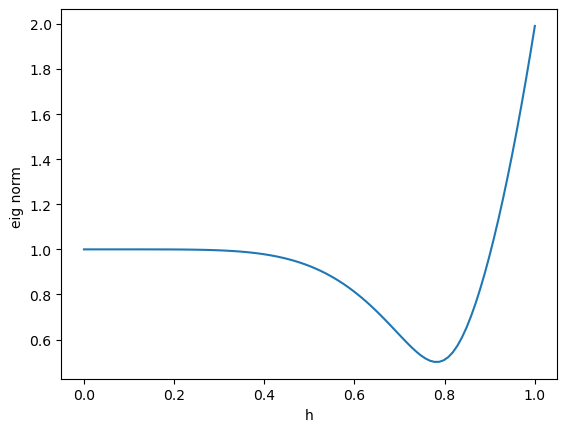

In [36]:
eignorms = np.zeros((100,))
hvec = np.linspace(0,1,100)
x_0 = np.array([0,0])
for k in range(len(eignorms)):
    hg = hvec[k]    
    eignorms[k] = np.max(abs(np.linalg.eigvals(forwarddiff.jacobian(fd_pendulum_rk4_global_h,x_0))))
plt.plot(hvec, eignorms)
plt.xlabel('h')
plt.ylabel('eig norm ')
plt.show()

In [42]:
def pendulum_backward_euler(func, x0, Tf, h):
    t = np.arange(0,Tf,h)
    x_hist = np.zeros((len(x0),len(t)))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        e = 1
        x_hist[:,k+1] = x_hist[:,k]
        while e > 1e-8:
            xn = x_hist[:,k] + h*func(x_hist[:,k+1])
            e = np.linalg.norm(xn - x_hist[:,k+1])
            x_hist[:,k+1] = xn
    
    return x_hist, t

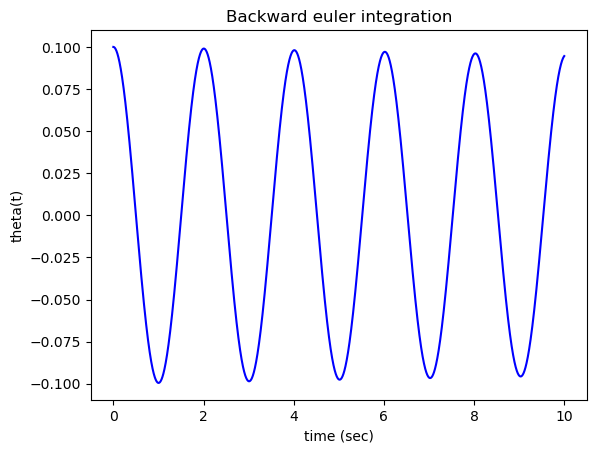

In [44]:
x0 = np.array([.1,0])
x_hist3, t_hist3 = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.001)
plt.figure()
plt.plot(t_hist3, x_hist3[0,:],'b-')
plt.xlabel('time (sec)')
plt.ylabel('theta(t)')
plt.title('Backward euler integration')
plt.show()